### Helper functions

In [ ]:
!pip install pydub ffmpeg     
!apt-get install ffmpeg  
!pip install mido           


In [ ]:
!mkdir ../data
!mkdir ../data/multimodal
!mkdir ../data/lidar

In [ ]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1dzX8OFyrMdpRajobHIImhwGhA31Tiun9' -O ../data/multimodal/C_Laser.wav

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1HiYo6ZnKrzlPOYyiROZckdf_c2Dq64i3' -O ../data/multimodal/C_MIDI.mid

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1p92ekdLRUccwpNNEKjS4pi8c3nd2f95q' -O ../data/multimodal/C_Sound.wav

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=12sit0maTiGfSR3jYSAMXyWB48kJiQS6m' -O ../data/multimodal/G_Laser.wav

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=19rK767VE7JDhrCggTwXznzS2n2jCcEfK' -O ../data/multimodal/G_MIDI.mid

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=17XoOdL3oFQHXetNi2Ud3y9yDySizLMUW' -O ../data/multimodal/G_Sound.wav

In [ ]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=175-nkjLuamln_d7ymtLKereXqJECS7lu' -O ../data/lidar/samples_midi.npy

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1VTKfypiWg5krRNECw8hyosX8Oz8m4BYM' -O ../data/lidar/samples_laser.npy

In [0]:
# For Audio:
# pip install pydub ffmpeg      ---> required
# sudo apt-get install ffmpeg   ---> optional

# For MIDI:
# pip install mido              ---> required

from pydub import AudioSegment 

def match_target_amplitude(sound, target_dBFS=-14): # default YouTube audio normalization level
    '''
    https://stackoverflow.com/questions/42492246/how-to-normalize-the-volume-of-an-audio-file-in-python-any-packages-currently-a
    '''
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


def detect_leading_silence(sound, silence_threshold=-25.0, chunk_size=50):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms
    iterate over chunks until you find the first one with sound
    https://stackoverflow.com/questions/29547218/remove-silence-at-the-beginning-and-at-the-end-of-wave-files-with-pydub
    '''
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

def trim_silence(sound, silence_threshold=-50, chunk_size=10):
    start_trim = detect_leading_silence(sound)
    end_trim = 0 # <- Do not trim the end   For trimming -> #detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    return trimmed_sound

In [0]:
import numpy

def get_sound_features(filepath, normalization=False, trimming=False):
    sound = AudioSegment.from_wav(filepath)
    if normalization:
        sound = match_target_amplitude(sound)
    if trimming:
        sound = trim_silence(sound, chunk_size=50) 
    return numpy.array(sound.get_array_of_samples())

### Data loading

In [0]:
from os import path
from mido import MidiFile 

data_path = "../data/multimodal/"
notes = ["C", "G"]
files = [("wav", "Laser"), 
         ("wav", "Sound"),
         ("mid", "MIDI")]

# READING

def read_wav(file_path):
    return get_sound_features(file_path)

def read_midi(file_path):
    elapsed = 0 # time in seconds
    midi = MidiFile(file_path)
    samples = None
    SAMPLE_RATE = 44100 # Hertz
    prev_velocity = 0
    for msg in midi:
        if msg.is_meta:
            # ignore meta messages, they should be of length 0 leading to no samples generated
            velocity = -1 
        else:
            velocity = msg.velocity
        length = msg.time
        elapsed += length
        samples_expected = int(numpy.round(elapsed * SAMPLE_RATE))
        if samples is None:
            samples = numpy.full(samples_expected, prev_velocity)
        else:
            samples_to_insert = samples_expected - len(samples)
            # inserting samples of same velocity
            curr_samples = numpy.full(samples_to_insert, prev_velocity)
            samples = numpy.concatenate((samples, curr_samples))
        prev_velocity = velocity
    return samples
        
read_function = {"wav" : read_wav,
                 "mid" : read_midi}

# POST_PROCESSING

def process_midi(midi, sound):
    # adding missing silence at midi data
    sound_length = len(sound)
    missing_length = sound_length - len(midi)
    if missing_length > 0:
        curr_samples = numpy.full(missing_length, 0) # zero velocity
        midi = numpy.concatenate((midi, curr_samples))
    return midi

def clamp_pwm(x):
    # converts analog signal into digital by clamping to 0/1 according to threshold
    x = x / x.max()
    #threshold = (x.max() - x.min()) / 2
    threshold = 0.0 # may need to experiment with this number. 
    # 0 ~ small value should be safe as the signal is usually between -0.2 ~ 1
    return numpy.where(x > threshold, 1, 0)

def smooth_pwm(x):
    # Laser data is encoded by Pulse-width modulation. Decoding the original data
    # by counting a fraction of data when the signal is in "on state" at each PWM signal window.
    # There are 490 PWM pulses per second, each of which encodes a measurement.
    PWM_FREQUENCY = 490
    # Calculating how many sound samples each measurement takes, which defines a PWM window
    LASER_SIGNAL_WINDOW = int(44100 / PWM_FREQUENCY)
    # Converting signal to 0/1 binary
    x = clamp_pwm(x)
    # Counting fraction of "1" state in each window, recovering the sensor reading
    start = 0
    is_last_0 = True
    curr_value = 0
    for i in range(len(x)):
        if x[i] == 1 and is_last_0:
            x[start : i] = curr_value
            start = i
            is_last_0 = False
            #print(last_1 + 1, i, curr_value)
        elif x[i] == 0 and not is_last_0:
            curr_value = i - start
            x[start : i] = curr_value
            start = i
            is_last_0 = True
            #print(last_1 + 1, i,curr_value)
        elif i == len(x) - 1:
            x[start : ] = curr_value
    return x / LASER_SIGNAL_WINDOW

def process_laser(laser):
    return smooth_pwm(laser)

# MAIN LOADING FUNCTION

def read_data():
    # structure of data - dictionary of dictionaries:
    # { Note_name : { data_file_name : time series data} } 
    data = dict()
    for note in notes:
        data[note] = dict()
        for file_type, file_name in files:
            file_path = path.join(data_path, "{}_{}.{}".format(note, file_name, file_type))
            data[note][file_name] = read_function[file_type](file_path)
        data[note]["MIDI"] = process_midi(data[note]["MIDI"], data[note]["Sound"])
        data[note]["Laser"] = process_laser(data[note]["Laser"])
    return data

In [0]:
data = read_data()
data

{'C': {'Laser': array([0.        , 0.        , 0.        , ..., 0.24444444, 0.24444444,
         0.24444444]),
  'MIDI': array([0, 0, 0, ..., 0, 0, 0]),
  'Sound': array([   0, 1792,  256, ...,    0,    0,    0], dtype=int32)},
 'G': {'Laser': array([0.        , 0.06666667, 0.06666667, ..., 0.14444444, 0.14444444,
         0.14444444]),
  'MIDI': array([0, 0, 0, ..., 0, 0, 0]),
  'Sound': array([   0, 1024,   -1, ...,    0,    0,    0], dtype=int32)}}

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_time_series(Sound, Laser, Midi, title, plot_samples=44100 * 60): # 1 minute by default 
    plt.xlabel("Time sample")
    plt.ylabel("Value")
    plt.title("Multi-modal time series: {}".format(title))
    plt.plot(Sound[:plot_samples] / Sound.max(), label="Sound")
  #  plt.plot(Laser[:plot_samples] / Laser.max(), label="Laser")
  #  plt.plot(Midi[:plot_samples] / Midi.max(), label="MIDI")
  #  plt.legend()

Time series lengths (Note C): 19205125 19205125 19205125


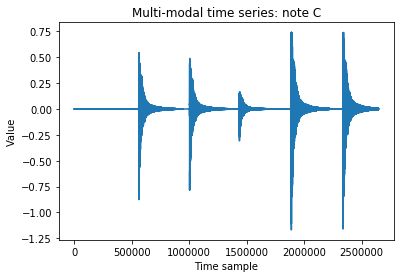

In [0]:
Sound_C, Laser_C, Midi_C = data["C"]["Sound"], data["C"]["Laser"], data["C"]["MIDI"]
print("Time series lengths (Note C):", len(Sound_C), len(Laser_C), len(Midi_C))
plot_time_series(Sound_C, Laser_C, Midi_C, "note C")

Time series lengths (Note G): 19098579 19098579 19098579


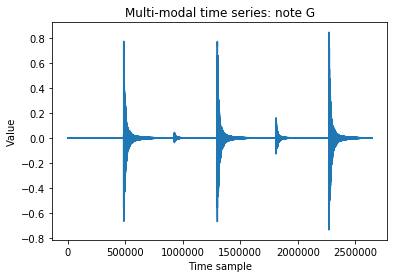

In [0]:
Sound_G, Laser_G, Midi_G = data["G"]["Sound"], data["G"]["Laser"], data["G"]["MIDI"]
print("Time series lengths (Note G):", len(Sound_G), len(Laser_G), len(Midi_G))
plot_time_series(Sound_G, Laser_G, Midi_G, "note G")
#plt.xlim(1810000, 1820000)

# Now we can use Laser, Sound, Midi time series to do the Machine Learning 

In [0]:
indices_C = []
indices_G = []

for i in range(Midi_C.shape[0]-1):
  if Midi_C[i] < Midi_C[i+1]:
    indices_C.append(i)

for i in range(Midi_G.shape[0]-1):
  if Midi_G[i] < Midi_G[i+1]:
    indices_G.append(i)

indC = numpy.asarray(indices_C)
indG = numpy.asarray(indices_G)

n_C, n_G = indC.shape[0], indG.shape[0]

Laser_C /= max(Laser_C)
Laser_G /= max(Laser_G)

onesec = 44100
t = onesec
#t = int(onesec/2)
#t = int(1.5*onesec)

features = numpy.zeros((n_C+n_G,2*t+1))
labels = numpy.zeros((n_C+n_G,))

for i in range(n_C):
  features[i,:] = Laser_C[indC[i]-t:indC[i]+t+1]
  labels[i] = Midi_C[indC[i]+1]

for i in range(n_G):
  features[n_C+i,:] = Laser_G[indG[i]-t:indG[i]+t+1]
  labels[n_C+i] = Midi_G[indG[i]+1]


print(n_C+n_G)


In [0]:
features.shape, labels.shape

In [0]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

def split_and_train(features, labels, alpha=0.1):
  X_train, X_test, Y_train, Y_test = train_test_split(features, labels)
  model = Ridge(alpha=alpha)
  #model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', early_stopping=False)
  model.fit(X_train, Y_train)
  return X_train, X_test, Y_train, Y_test, model

def evaluate_model(X_train, X_test, Y_train, Y_test, model, print_accuracy=True):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)
  if print_accuracy:
    print("Training accuracy:", mean_squared_error(Y_train, Y_train_pred))
    print("Testing accuracy:", mean_squared_error(Y_test, Y_test_pred) ** 0.5)
   # print("Training accuracy:", accuracy_score(Y_train, Y_train_pred))
    #print("Testing accuracy:", accuracy_score(Y_test, Y_test_pred))
  return Y_train_pred, Y_test_pred

#X_train, X_test, Y_train, Y_test, model = split_and_train(features, labels)
#Y_train_pred, Y_test_pred = evaluate_model(X_train, X_test, Y_train, Y_test, model)

In [0]:
print("True", Y_test)
print("Pred", [int(x) for x in Y_test_pred])
print("Err ", [int(x) for x in abs(Y_test-Y_test_pred)])


# Regression mode with MLP for Laser -> MIDI

In [0]:
import numpy as np 
# Uniting C and G and dividing MIDI by 127 to normalize to (0, 1)
Laser = numpy.concatenate((Laser_C, Laser_G))
Midi = numpy.concatenate((Midi_C, Midi_G)) / 127.0
#Laser = np.arange(10)
#Midi = np.array([2,2,2,2,3,1,3,3,3,3])
# Creating slices of 1 second (past Laser) --> current value of MIDI
# There will be many resulting examples, controlling step size to ensure that data fits into memory
STEP_SIZE = 44100 // 100 # every N second - one window 
WINDOW_SIZE = 44100 // 50 #  how many samples to use in each input example

def sliding_window(data, step, window): 
  # transforming 1D into 2D data, taking window-sized slices each step
  result = np.zeros(((len(data) - window) // step, window))
  for i in range(len(result)):
    start_idx = i * step
    end_idx = start_idx + window
    result[i] = data[start_idx : end_idx]
  return result

def sliding_XY(X, Y, step, window):
  # Using sliding window for X (past values of X)
  # and taking 1 value from Y for each slice of X (current value of Y)
  # also setting Y to -1 if there were no chages in Midi in the window
  # because if there were no changes, prediction is impossible
  X = sliding_window(X, step, window)
  Y = sliding_window(Y, step, window)
  # checking if each row contains same values to set target to -1
  is_same = np.all(Y[:, :-1] == Y[:, 1:], axis=-1)
  Y = np.where(is_same, -1, Y[:, -1])
  return X, Y
  
Laser, Midi = sliding_XY(Laser, Midi, STEP_SIZE, WINDOW_SIZE)

# Removing unpredictable -1 values
good_idx = Midi != -1
Midi = Midi[good_idx]
Laser = Laser[good_idx]

print(Laser.shape, Midi.shape)

(333, 882) (333,)


In [0]:
def get_velocities(X, filter_window=50*3):
  filter_window = filter_window // 3 * 3 # should be multiply of three
  filter_kernel = np.zeros(filter_window)
  filter_kernel[:filter_window // 3] = 1 
  filter_kernel[filter_window * 2 // 3:] = -1 # differentiating filter (simple)
  filter_kernel /= np.sum(np.abs(filter_kernel)) # normalizing the kernel
  if X.ndim == 2:
    velocities = np.apply_along_axis(
        lambda m: np.convolve(m, filter_kernel, mode="valid"),
        axis=-1, arr=np.pad(X, ((0,0), (filter_window, filter_window)), mode='edge'))
  elif X.ndim == 1:
    padded = np.pad(X, ((filter_window, filter_window),), mode='edge')
    velocities = np.convolve(padded, filter_kernel, mode="valid"),
  return velocities

def add_velocity_features(X, filter_window=50*3):
  ''' if X contains positions on axis 1, 
      adds same amount of features containing position differences
      at each timestamp: X[t+1] - X[t] '''
  velocities = get_velocities(X, filter_window)
  #plt.plot(X[16].flatten())
  #plt.plot(velocities[16].flatten())
  return np.hstack((X, velocities))



(333, 1915)


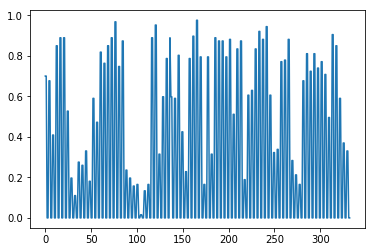

In [0]:
Laser = add_velocity_features(Laser)
print(Laser.shape)

plt.plot(Midi[:1000])

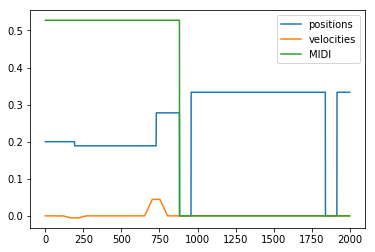

In [0]:
plt.plot(Laser[25:50, :Laser.shape[-1] // 2 + 1].flatten()[:2000], label="positions")
plt.plot(Laser[25:50, Laser.shape[-1] // 2 + 1:].flatten()[:2000], label="velocities")
plt.plot(np.repeat(Midi[25:50], WINDOW_SIZE)[:2000], label='MIDI')

plt.legend()

In [0]:
X_train, X_test, Y_train, Y_test, model = split_and_train(Laser, Midi, alpha=10)

In [0]:
# The accuracy reported is normalized because Y values are normalized too
# So on current sensor data we have around 26% error. I couldn't go lower so far
Y_train_pred, Y_test_pred = evaluate_model(X_train, X_test, Y_train, Y_test, model)

Training accuracy: 0.06442907631117614
Testing accuracy: 0.26965043793861226


# RNN Sequence to Sequence model

### Simple example on generated data

Using TensorFlow backend.


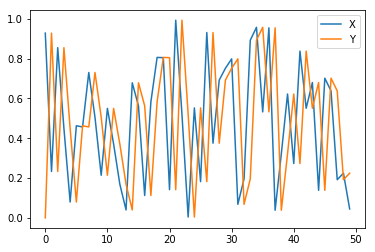

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

# Simple task of predicting delayed value of a sequence
# Y[t] = X[t-SHIFT]
SHIFT = 1
TIMESTAMPS = 1000
BATCH=128
TRAINING_BATCHES = 32
TESTING_BATCHES = 4
EXAMPLES = BATCH * (TRAINING_BATCHES + TESTING_BATCHES)

X = np.random.uniform(size=(EXAMPLES, TIMESTAMPS, 1))
Y = np.copy(X)
X = X[:, SHIFT:, :]
Y = Y[:, :-SHIFT, :]
Y[:, :SHIFT, :] = 0

plt.plot(X[0, :50].flatten(), label="X")
plt.plot(Y[0, :50].flatten(), label="Y")
plt.legend()

In [0]:
def create_model(batch_len, input_len=TIMESTAMPS-SHIFT, hidden_neurons=64):
  model = Sequential()
  model.add(LSTM(hidden_neurons, input_shape=(input_len, 1), batch_size=batch_len, return_sequences=True, stateful=True))
  model.add(LSTM(hidden_neurons, batch_size=batch_len, return_sequences=True, stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='rmsprop')
  return model

Instructions for updating:
Colocations handled automatically by placer.
[(4096, 999, 1), (512, 999, 1), (4096, 999, 1), (512, 999, 1)]


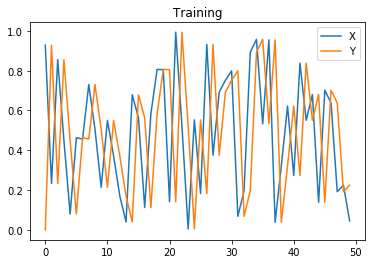

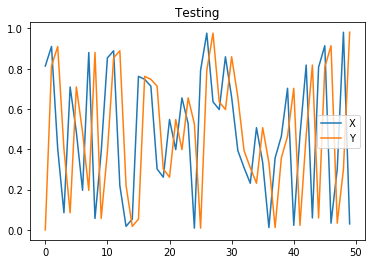

In [0]:
#%%time
#from sklearn.model_selection import train_test_split
model = create_model(batch_len=BATCH)

EXAMPLES = len(X) // BATCH
X = X[:EXAMPLES * BATCH]
Y = Y[:EXAMPLES * BATCH]

# DO NOT RANDOMLY SPLIT, instead use past for training and future for testing
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
SPLIT_IDX = BATCH * TRAINING_BATCHES 
X_train, X_test, Y_train, Y_test = X[:SPLIT_IDX], X[SPLIT_IDX:], Y[:SPLIT_IDX], Y[SPLIT_IDX:]
print([d.shape for d in (X_train, X_test, Y_train, Y_test)])

plt.figure()
plt.title("Training")
plt.plot(X_train[0, :50].flatten(), label="X")
plt.plot(Y_train[0, :50].flatten(), label="Y")
plt.legend()

plt.figure()
plt.title("Testing")
plt.plot(X_test[0, :50].flatten(), label="X")
plt.plot(Y_test[0, :50].flatten(), label="Y")
plt.legend()

In [0]:
model.fit(X_train, Y_train, epochs=3, batch_size=BATCH, verbose=True, 
          validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 4096 samples, validate on 512 samples
Epoch 1/3
4096/4096 [==============================] - 88s 21ms/step - loss: 0.0927 - val_loss: 0.0780
Epoch 2/3
4096/4096 [==============================] - 84s 20ms/step - loss: 0.0712 - val_loss: 0.0636
Epoch 3/3
4096/4096 [==============================] - 83s 20ms/step - loss: 0.0570 - val_loss: 0.0505


In [0]:
Y_train_pred = model.predict(X_train, batch_size=BATCH)
Y_test_pred = model.predict(X_test, batch_size=BATCH)


In [0]:
from sklearn.metrics import mean_squared_error
print("MSE Train:", mean_squared_error(Y_train.flatten(), Y_train_pred.flatten()))
print("MSE Test:", mean_squared_error(Y_test.flatten(), Y_test_pred.flatten()))
print("MSE Random:", mean_squared_error(Y_test.flatten(), np.zeros_like(Y_test).flatten()))

MSE Train: 0.05047034842985016
MSE Test: 0.05050470846114269
MSE Random: 0.3337234287447771


## Lidar -> MIDI modeling with RNN

(515872,) (515872,)


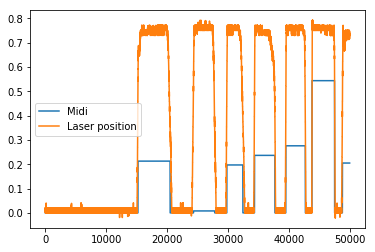

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import numpy

USE_LIDAR_DATA = True # Use data from newer sensor, containing Midi and Laser sensor values, no sound for now
if USE_LIDAR_DATA:
  Sound = None
  Laser = np.load("../data/lidar/samples_laser.npy")
  Midi = np.load("../data/lidar/samples_midi.npy")
  
  # NORMALIZING!
  Laser = Laser - np.quantile(Laser, q=0.1)  # Quantile... to center the signal and remove outliers
  # can also use mean or median here
  Laser /= np.max(Laser) - np.min(Laser)
  Midi /= 127.0
  
  SAMPLING_FREQUENCY = 2000
  print(Midi.shape, Laser.shape)
  plt.plot(Midi[:50000], label="Midi")
  plt.plot(Laser[:50000], label="Laser position")
  
  #Velocities = get_velocities(Laser)
  #plt.plot(Velocities[:50000], label="Laser velocity")
  
  plt.legend()
else:
  Laser = numpy.concatenate((Laser_C, Laser_G))
  Midi = numpy.concatenate((Midi_C, Midi_G)) / 127.0
  SAMPLING_FREQUENCY = 44100

In [0]:
TIMESTAMPS = SAMPLING_FREQUENCY * 2
EXAMPLES = len(Laser) // TIMESTAMPS
BATCH=16

Laser = Laser[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, 1))
Midi = Midi[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, 1))

#X_train, X_test, Y_train, Y_test = train_test_split(Laser, Midi)
def time_split(X, Y, train_fraction=0.8):
  SPLIT_IDX = int(len(X) * train_fraction) 
  X_train, X_test, Y_train, Y_test = X[:SPLIT_IDX], X[SPLIT_IDX:], Y[:SPLIT_IDX], Y[SPLIT_IDX:]
  return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = time_split(Laser, Midi)
  
X_train, X_test, Y_train, Y_test = (
    X_train[:len(X_train) // BATCH * BATCH], X_test[:len(X_test) // BATCH * BATCH], 
    Y_train[:len(X_train) // BATCH * BATCH], Y_test[:len(X_test) // BATCH * BATCH])

model = create_model(batch_len=BATCH, input_len=Laser.shape[1])
print(Midi.shape, Laser.shape)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(128, 4000, 1) (128, 4000, 1)
(96, 4000, 1) (96, 4000, 1) (16, 4000, 1) (16, 4000, 1)


In [0]:

model.fit(X_train, Y_train, epochs=4, batch_size=BATCH, verbose=True, 
          validation_data=(X_test, Y_test))

Train on 96 samples, validate on 16 samples
Epoch 1/4
96/96 [==============================] - 71s 741ms/step - loss: 0.1114 - val_loss: 0.0988
Epoch 2/4
96/96 [==============================] - 70s 728ms/step - loss: 0.0640 - val_loss: 0.0921
Epoch 3/4
96/96 [==============================] - 70s 729ms/step - loss: 0.0593 - val_loss: 0.0859
Epoch 4/4
96/96 [==============================] - 70s 729ms/step - loss: 0.0557 - val_loss: 0.0856


In [0]:
from sklearn.metrics import mean_squared_error
Y_train_pred = model.predict(X_train, batch_size=BATCH)
Y_test_pred = model.predict(X_test, batch_size=BATCH)
print("MSE Train:", mean_squared_error(Y_train.flatten(), Y_train_pred.flatten()))
print("MSE Test:", mean_squared_error(Y_test.flatten(), Y_test_pred.flatten()))
print("MSE Random (Mean prediction):", mean_squared_error(Y_test.flatten(), np.mean(Y_train) + np.zeros_like(Y_test).flatten()))

MSE Train: 0.06362739423102685
MSE Test: 0.08577145039006878
MSE Random (Mean prediction): 0.15095692534290334


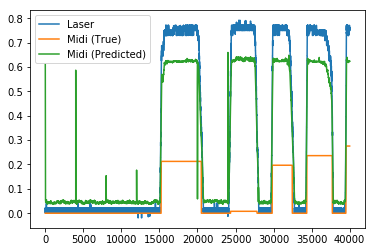

In [0]:
plt.plot(X_train[:10].flatten(), label="Laser")
plt.plot(Y_train[:10].flatten(), label="Midi (True)")
plt.plot(Y_train_pred[:10].flatten(), label="Midi (Predicted)")

#plt.plot(X_test[:3].flatten(), label="Laser")
#plt.plot(Y_test[:3].flatten(), label="Midi (True)")
#plt.plot(Y_test_pred[:3].flatten(), label="Midi (Predicted)")

plt.legend()

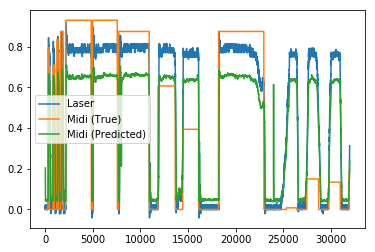

In [0]:
plt.plot(X_test[8:20].flatten(), label="Laser")
plt.plot(Y_test[8:20].flatten(), label="Midi (True)")
plt.plot(Y_test_pred[8:20].flatten(), label="Midi (Predicted)")
plt.legend()

## Sound modeling with RNN

### Note that for Sound Modeling - Wavenet model should be used.
### Which is confirmed by the fact that simple RNN cannot generate sound, as seen below

In [0]:
Sound_C = np.true_divide(Sound_C,max(Sound_C))
Sound_G = np.true_divide(Sound_G,max(Sound_G))

Sound = numpy.concatenate((Sound_C, Sound_G))
Midi = numpy.concatenate((Midi_C, Midi_G)) / 127.0

TIMESTAMPS = 44100 // 15
EXAMPLES = len(Midi) // TIMESTAMPS
BATCH=256

def time_split(X, Y, train_fraction=0.5):
  SPLIT_IDX = int(len(X) * train_fraction) 
  X_train, X_test, Y_train, Y_test = X[:SPLIT_IDX], X[SPLIT_IDX:], Y[:SPLIT_IDX], Y[SPLIT_IDX:]
  return X_train, X_test, Y_train, Y_test


Sound = Sound[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, 1))
Midi = Midi[:TIMESTAMPS * EXAMPLES].reshape((EXAMPLES, TIMESTAMPS, 1))

#X_train, X_test, Y_train, Y_test = train_test_split(Midi, Sound)
X_train, X_test, Y_train, Y_test = time_split(Midi, Sound)

X_train, X_test, Y_train, Y_test = (
    X_train[:len(X_train) // BATCH * BATCH], X_test[:len(X_test) // BATCH * BATCH], 
    Y_train[:len(X_train) // BATCH * BATCH], Y_test[:len(X_test) // BATCH * BATCH])

model = create_model(batch_len=BATCH, input_len=Midi.shape[1])
print(X_train.shape, Y_train.shape)

model.fit(X_train, Y_train, epochs=4, batch_size=BATCH, verbose=True, 
          validation_data=(X_test, Y_test))

(8448, 2205, 1) (8448, 2205, 1)
Train on 8448 samples, validate on 8448 samples
Epoch 1/4
8448/8448 [==============================] - 304s 36ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 2/4
8448/8448 [==============================] - 300s 36ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 3/4
8448/8448 [==============================] - 300s 36ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 4/4
8448/8448 [==============================] - 300s 36ms/step - loss: 0.0030 - val_loss: 0.0017


In [0]:
Y_train_pred = model.predict(X_train, batch_size=BATCH)
Y_test_pred = model.predict(X_test, batch_size=BATCH)
print("MSE Train:", mean_squared_error(Y_train.flatten(), Y_train_pred.flatten()))
print("MSE Test:", mean_squared_error(Y_test.flatten(), Y_test_pred.flatten()))
print("MSE Random (Mean prediction):", mean_squared_error(Y_test.flatten(), np.mean(Y_train) + np.zeros_like(Y_test).flatten()))

MSE Train: 0.002938813835002008
MSE Test: 0.0017331263332695229
MSE Random (Mean prediction): 0.0017158068974256718


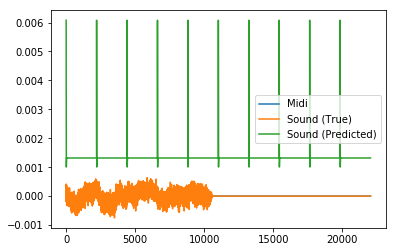

In [0]:
plt.plot(X_test[:10].flatten(), label="Midi")
plt.plot(Y_test[:10].flatten(), label="Sound (True)")
plt.plot(Y_test_pred[:10].flatten(), label="Sound (Predicted)")
plt.legend()